In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (9,4)

DATA_PATH = Path("app/data/Houston-311-Clean.csv")
RANDOM_STATE = 42


In [7]:
df = pd.read_csv(DATA_PATH)
df.head()

/var/folders/_v/f9jlhvnd2xg9kybwfc9yh6nw0000gn/T/ipykernel_31144/3278585135.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,CASE NUMBER,NEIGHBORHOOD,DEPARTMENT,DIVISION,CASE TYPE,CREATED DATE,CLOSED DATE,LATITUDE,LONGITUDE,CATEGORY
0,12091834-101002444724,EAST LITTLE YORK / HOMESTEAD,Public Works,Houston Water,Fire Hydrant,2017-01-01 00:01:48,2017-01-01 11:20:02,29.856743,-95.296945,Public Infrastructure / Engineering
1,12091835-101002444725,NORTHSIDE/NORTHLINE,Public Works,Houston Water,Fire Hydrant,2017-01-01 00:07:29,2017-01-01 04:50:02,29.830449,-95.367947,Public Infrastructure / Engineering
2,101002444726,MID WEST,Public Works,Transportation Drainage Operations,Traffic Signal Maintenance,2017-01-01 00:14:04,2017-01-01 00:23:57,29.722099,-95.539078,Traffic Signals & Signs
3,101002444727,WASHINGTON AVENUE COALITION / MEMORIAL PARK,Public Works,Capitol Improvement Planning,MultiFamily Habitability Violation,2017-01-01 00:17:23,2017-01-04 14:01:37,29.773859,-95.402572,Public Health & Housing
4,12091836-101002444730,GREATER UPTOWN,Public Works,Houston Water,Water Leak,2017-01-01 00:30:48,2017-02-02 13:20:06,29.733522,-95.466104,Water Service & Leaks


In [8]:
df.describe

<bound method NDFrame.describe of                    CASE NUMBER                                 NEIGHBORHOOD  \
0        12091834-101002444724                 EAST LITTLE YORK / HOMESTEAD   
1        12091835-101002444725                          NORTHSIDE/NORTHLINE   
2                 101002444726                                     MID WEST   
3                 101002444727  WASHINGTON AVENUE COALITION / MEMORIAL PARK   
4        12091836-101002444730                               GREATER UPTOWN   
...                        ...                                          ...   
3396455             2400454470                                   BRAYS OAKS   
3396456    12664839-2400454469                                   NORTHSHORE   
3396457             2400454468                                   NORTHSHORE   
3396458             2400454467                           SPRING BRANCH WEST   
3396459             2400454466                                   SHARPSTOWN   

                 

In [9]:
df.dtypes

CASE NUMBER      object
NEIGHBORHOOD     object
DEPARTMENT       object
DIVISION         object
CASE TYPE        object
CREATED DATE     object
CLOSED DATE      object
LATITUDE        float64
LONGITUDE       float64
CATEGORY         object
dtype: object

In [10]:
#converting dates to datetime format
date_cols = ["CREATED DATE", "CLOSED DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")  # invalid : NaT

#converting numeric columns to numeric types
num_cols = ["LATITUDE", "LONGITUDE"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # invalid : NaN

#convert categorial columns into categories
cat_cols = ['CASE NUMBER', 'NEIGHBORHOOD', 'DEPARTMENT', 'DIVISION', 'CASE TYPE']
for col in cat_cols:
    df[col] = df[col].astype("category")

print(df.head())
print(df.shape)
print(df.dtypes)

             CASE NUMBER                                 NEIGHBORHOOD  \
0  12091834-101002444724                 EAST LITTLE YORK / HOMESTEAD   
1  12091835-101002444725                          NORTHSIDE/NORTHLINE   
2           101002444726                                     MID WEST   
3           101002444727  WASHINGTON AVENUE COALITION / MEMORIAL PARK   
4  12091836-101002444730                               GREATER UPTOWN   

     DEPARTMENT                            DIVISION  \
0  Public Works                       Houston Water   
1  Public Works                       Houston Water   
2  Public Works  Transportation Drainage Operations   
3  Public Works        Capitol Improvement Planning   
4  Public Works                       Houston Water   

                            CASE TYPE        CREATED DATE         CLOSED DATE  \
0                        Fire Hydrant 2017-01-01 00:01:48 2017-01-01 11:20:02   
1                        Fire Hydrant 2017-01-01 00:07:29 2017-01-01

In [11]:
# Aggregate by date
overall_ts = (
    df.groupby(pd.Grouper(key='CREATED DATE', freq='M'))
      .size()
      .reset_index(name='y')
)

# Rename columns for Prophet
overall_ts = overall_ts.rename(columns={'CREATED DATE': 'ds'})
overall_ts = overall_ts.sort_values('ds')
overall_ts.head()

/var/folders/_v/f9jlhvnd2xg9kybwfc9yh6nw0000gn/T/ipykernel_31144/3297145445.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='CREATED DATE', freq='M'))


,ds,y
0,2016-01-31,29448
1,2016-02-29,28153
2,2016-03-31,32681
3,2016-04-30,33048
4,2016-05-31,31904


In [12]:
# Train
m = Prophet(interval_width=0.95, daily_seasonality=True)
modle = m.fit(overall_ts)

14:14:24 - cmdstanpy - INFO - Chain [1] start processing
14:14:24 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = m.make_future_dataframe(periods=12, freq='ME')
forecast = m.predict(future)
# forecast.to_csv("data/prophet_forecast.csv", index=False)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-31,29610.487515,24794.606266,38596.715757,29610.487515,29610.487515,1717.001372,1717.001372,1717.001372,825.872646,825.872646,825.872646,891.128726,891.128726,891.128726,0.0,0.0,0.0,31327.488887
1,2016-02-29,29620.976644,21031.475649,35050.278191,29620.976644,29620.976644,-1876.908436,-1876.908436,-1876.908436,825.872646,825.872646,825.872646,-2702.781082,-2702.781082,-2702.781082,0.0,0.0,0.0,27744.068208
2,2016-03-31,29632.189160,22148.012092,36656.833406,29632.189160,29632.189160,40.527749,40.527749,40.527749,825.872646,825.872646,825.872646,-785.344897,-785.344897,-785.344897,0.0,0.0,0.0,29672.716909
3,2016-04-30,29643.039983,23127.564530,36550.716444,29643.039983,29643.039983,-306.816637,-306.816637,-306.816637,825.872646,825.872646,825.872646,-1132.689283,-1132.689283,-1132.689283,0.0,0.0,0.0,29336.223346
4,2016-05-31,29654.252498,25227.494087,38886.444254,29654.252498,29654.252498,2173.955204,2173.955204,2173.955204,825.872646,825.872646,825.872646,1348.082558,1348.082558,1348.082558,0.0,0.0,0.0,31828.207702


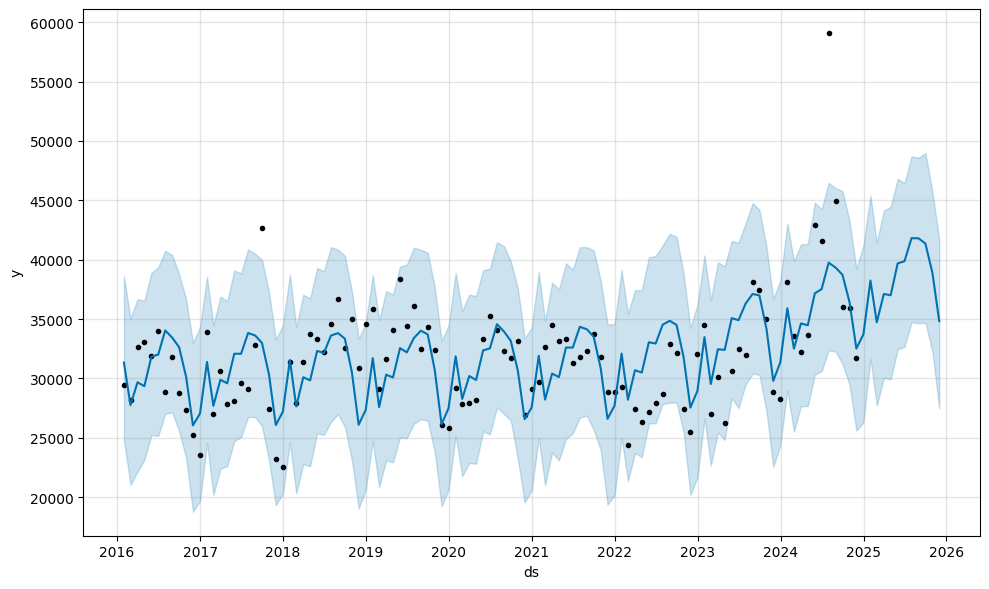

In [16]:
plot1 = m.plot(forecast)

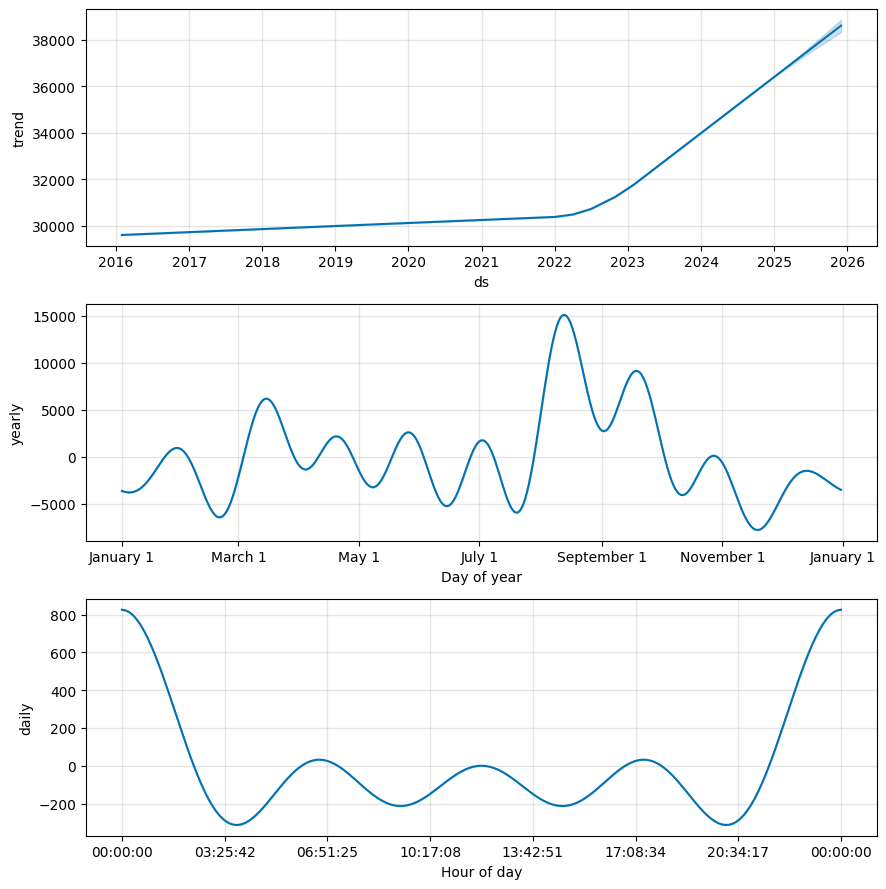

In [17]:
plot2 = m.plot_components(forecast)

In [18]:
# Merge forecasted values with actuals
results = overall_ts.merge(forecast, on='ds', how='left')

# Keep only training portion (historical)
historical = results[results['ds'] <= overall_ts['ds'].max()]


In [19]:
# Calculate error metrics
y_true = historical['y']
y_pred = historical['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE:  2663.56
RMSE: 3587.29
MAPE: 8.28%


In [20]:
# Keep only periods that exist in your original data
actual = overall_ts.set_index("ds")
predicted = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]

# Join actuals with predictions
compare = actual.join(predicted, how="left")

# Compute residuals (errors)
compare["error"] = compare["y"] - compare["yhat"]
compare.head()


,y,yhat,yhat_lower,yhat_upper,error
ds,,,,,
2016-01-31,29448,31327.488887,24794.606266,38596.715757,-1879.488887
2016-02-29,28153,27744.068208,21031.475649,35050.278191,408.931792
2016-03-31,32681,29672.716909,22148.012092,36656.833406,3008.283091
2016-04-30,33048,29336.223346,23127.564530,36550.716444,3711.776654
2016-05-31,31904,31828.207702,25227.494087,38886.444254,75.792298


In [21]:
bias = compare["error"].mean()
print("Mean Bias:", bias)

Mean Bias: 0.17477226503210785


In [22]:
compare["month"] = compare.index.month
monthly_bias = compare.groupby("month")["error"].mean()
print(monthly_bias)

month
1     14.909641
2     25.811665
3     24.593967
4      7.495015
5     -6.631796
6    -19.230809
7     -4.973175
8      3.711760
9    -12.258927
10   -20.818589
11   -13.300571
12     3.115876
Name: error, dtype: float64


In [23]:
# Example setup
category_col = "NEIGHBORHOOD"
date_col = "CREATED DATE"  

results = []

for cat, group in df.groupby(category_col, observed=True):
    # Aggregate monthly counts
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )

    # Skip if too few data points
    if len(ts) < 24:
        continue
    
    # Train-test split (e.g., last 6 months for testing)
    train = ts[:-6]
    test = ts[-6:]

    # Fit Prophet
    m = Prophet()
    m.fit(train)

    # Make future and predict only for test dates
    future = m.make_future_dataframe(periods=6, freq="M")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values

    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100

    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME'

                                       Category         MAE         RMSE  \
72                       SOUTH BELT / ELLINGTON   51.358819    60.933750   
25                                  FOURTH WARD   11.448317    16.400001   
38                                      GULFTON   30.445006    43.717739   
57                                      MIDTOWN   32.611835    45.038667   
79                                    SUNNYSIDE  107.683830   147.800795   
31                           GREATER HOBBY AREA   44.570145    50.926907   
58                                     MINNETEX   30.829667    38.057754   
19                               EDGEBROOK AREA   38.844925    49.402300   
70                                   SHARPSTOWN   90.709775   112.434572   
3                                         ALIEF  174.127492   197.540182   
56                                     MID WEST   77.538968   108.163233   
9                                    CARVERDALE   14.399388    18.381244   
29          

/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [36]:
category_col = "DEPARTMENT" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    # Aggregate monthly counts
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )

    # Skip if too few data points
    if len(ts) < 24:
        continue
    
    # Train-test split (e.g., last 6 months for testing)
    train = ts[:-6]
    test = ts[-6:]

    # Fit Prophet
    m = Prophet()
    m.fit(train)

    # Make future and predict only for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values

    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100

    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing
14:43:13 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing
14:43:13 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing
14:43:13 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1]

                                 Category          MAE         RMSE  \
13                          Neighborhoods   222.379828   271.294841   
16                           Public Works  1526.895719  2542.380038   
14                     Parking Management   151.489448   189.960380   
15                   Parks and Recreation   367.376489   581.947539   
7                                  Health   134.049077   154.762277   
12                           Mayor Office   223.057566   291.266165   
17                 Solid Waste Management  7713.537522  9496.073600   
4                                 Finance     5.840725     6.665590   
5                        Fleet Management     1.278656     1.735824   
6                        General Services     3.068491     4.220930   
0                            311 HelpLine   293.800873   402.712612   
3                       External Referral    28.073468    30.221879   
9                 Houston Fire Department   400.872960   503.289162   
2     

In [26]:
category_col = "DIVISION" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    # Aggregate monthly counts
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )

    # Skip if too few data points
    if len(ts) < 24:
        continue
    
    # Train-test split (e.g., last 6 months for testing)
    train = ts[:-6]
    test = ts[-6:]

    # Fit Prophet
    m = Prophet()
    m.fit(train)

    # Make future and predict only for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values

    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100

    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1] done processing
14:16:30 - cmdstanpy - INFO - Chain [1] start processing
14:16:30 - cmdstanpy - INFO - Chain [1]

                              Category          MAE         RMSE     MAPE (%)
20                       Houston Water   776.346147   896.922385    12.262431
22                      Investigations   280.934580   297.249425    12.620678
28                 Parking Enforcement   138.538362   177.765131    13.004245
35                           Recycling   378.538390   416.798081    13.882111
25           Mayor's Assistance Office    58.607413    79.867489    16.990419
1                     Capital Projects    16.697822    20.107609    22.824658
32           Public Information Office     6.722160     8.234035    23.772451
12          Facilities and Maintenance    39.082378    54.349548    24.382829
37  Transportation Drainage Operations  2248.823096  3210.137311    24.973014
11                Environmental Health   142.200346   157.711177    26.866128
7                  Customer Escalation   454.627055   514.412157    26.870689
18               Greenspace Management    67.801828   102.922180

14:26:14 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 11.98%


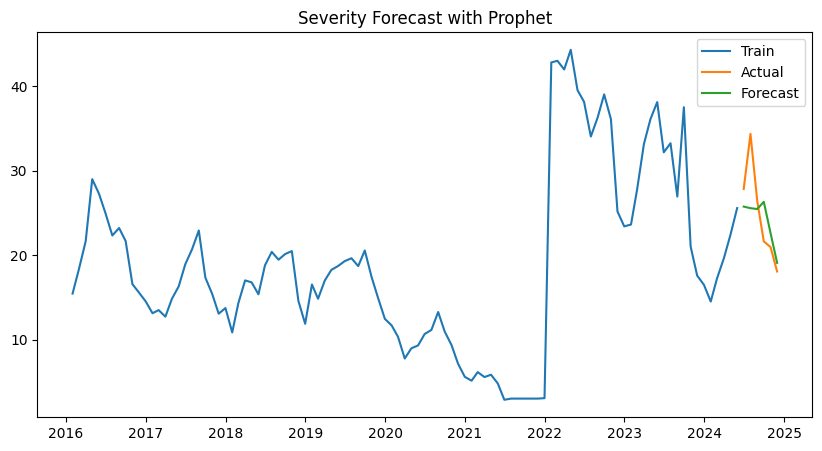

In [33]:
# Fill missing CLOSED DATEs with estimated closure based on median duration
if df["CLOSED DATE"].isna().any():
    median_duration = (df["CLOSED DATE"] - df["CREATED DATE"]).dropna().dt.days.median()
    df["CLOSED DATE"] = df["CLOSED DATE"].fillna(df["CREATED DATE"] + pd.to_timedelta(median_duration, unit="D"))

df["SEVERITY_SCORE"] = (df["CLOSED DATE"] - df["CREATED DATE"]).dt.days

df = df.dropna(subset=["SEVERITY_SCORE", "CREATED DATE"])

# Monthly average severity
ts = (
    df.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["SEVERITY_SCORE"]
    .mean()
    .reset_index()
    .rename(columns={"CREATED DATE": "ds", "SEVERITY_SCORE": "y"})
)

# Fill missing months via interpolation
full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
ts = ts.set_index("ds").reindex(full_range)
ts["y"] = (
    ts["y"]
    .interpolate()
    .bfill()
    .ffill()
)
ts = ts.rename_axis("ds").reset_index()

train = ts.iloc[:-6]
test = ts.iloc[-6:]

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

future = model.make_future_dataframe(periods=12, freq="ME")
forecast = model.predict(future)

# Join predictions with test set
pred = forecast[["ds", "yhat"]].merge(test, on="ds", how="inner")

# Compute MAPE
mape = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(pred["ds"], pred["yhat"], label="Forecast")
plt.legend()
plt.title("Severity Forecast with Prophet")
plt.show()


In [38]:
import ssl
import json
import geopandas as gpd
from urllib.request import urlopen

url = "https://mycity2.houstontx.gov/pubgis02/rest/services/HoustonMap/Administrative_Boundary/MapServer/3/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

with urlopen(url) as response:
    data = json.load(response)

hoods = gpd.GeoDataFrame.from_features(data["features"], crs="EPSG:4326")


In [39]:
hoods.head()

,geometry,OBJECTID,POLYID,SNBNAME,COUNCIL_ACTIVE,RECOGNITION_DATE,SnbrInfoURL,WeCan,Top10,CEA_FLAG,Shape.STArea(),Shape.STLength()
0,"POLYGON ((-95.38581 29.76158, -95.38575 29.759...",1,60,FOURTH WARD,None,NaN,http://www.houstontx.gov/superneighborhoods/60...,Y,None,N,1.296982e+07,16572.026024
1,"POLYGON ((-95.32015 29.75616, -95.32066 29.756...",2,63,SECOND WARD,Yes,1.210637e+12,http://www.houstontx.gov/superneighborhoods/63...,Y,Y,Y,8.040472e+07,43118.770016
2,"POLYGON ((-95.34735 29.76624, -95.34498 29.767...",3,61,DOWNTOWN,None,NaN,http://www.houstontx.gov/superneighborhoods/61...,None,None,N,7.550023e+07,39256.387491
3,"POLYGON ((-95.25626 29.77367, -95.26375 29.775...",4,59,CLINTON PARK TRI-COMMUNITY,Yes,9.746784e+11,http://www.houstontx.gov/superneighborhoods/59...,Y,None,Y,7.655352e+07,59784.697729
4,"POLYGON ((-95.45388 29.78077, -95.45785 29.782...",5,21,GREATER UPTOWN,None,NaN,http://www.houstontx.gov/superneighborhoods/21...,None,None,N,2.297921e+08,75759.390142
